In [ ]:
!pip install unrar
!unrar x "/content/EchoVision Data"


# **Import Modules**

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import seaborn as sns
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# **DATA**

In [ ]:
df=pd.read_csv("/content/EchoVision Data/FileList.csv")
df.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [ ]:
df.shape

(10030, 9)

In [ ]:
df.columns

Index(['FileName', 'EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS',
       'NumberOfFrames', 'Split'],
      dtype='object')

In [ ]:
df.describe()

,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames
count,10030.000000,10030.000000,10030.000000,10030.000000,10030.000000,10030.000000,10030.000000
mean,55.748248,43.427433,91.324572,112.392423,112.547159,51.077767,176.533998
std,12.371483,35.828098,45.663554,16.040604,22.366033,6.238707,57.879145
min,6.907258,4.350710,12.618671,112.000000,112.000000,18.000000,28.000000
25%,51.601387,23.686339,62.166669,112.000000,112.000000,50.000000,144.000000
50%,59.209109,33.596750,82.084190,112.000000,112.000000,50.000000,171.000000
75%,63.958740,49.107316,108.288686,112.000000,112.000000,50.000000,201.000000
max,96.967237,612.489815,695.036025,768.000000,1040.000000,138.000000,1002.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10030 entries, 0 to 10029
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FileName        10030 non-null  object 
 1   EF              10030 non-null  float64
 2   ESV             10030 non-null  float64
 3   EDV             10030 non-null  float64
 4   FrameHeight     10030 non-null  int64  
 5   FrameWidth      10030 non-null  int64  
 6   FPS             10030 non-null  int64  
 7   NumberOfFrames  10030 non-null  int64  
 8   Split           10030 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 705.4+ KB


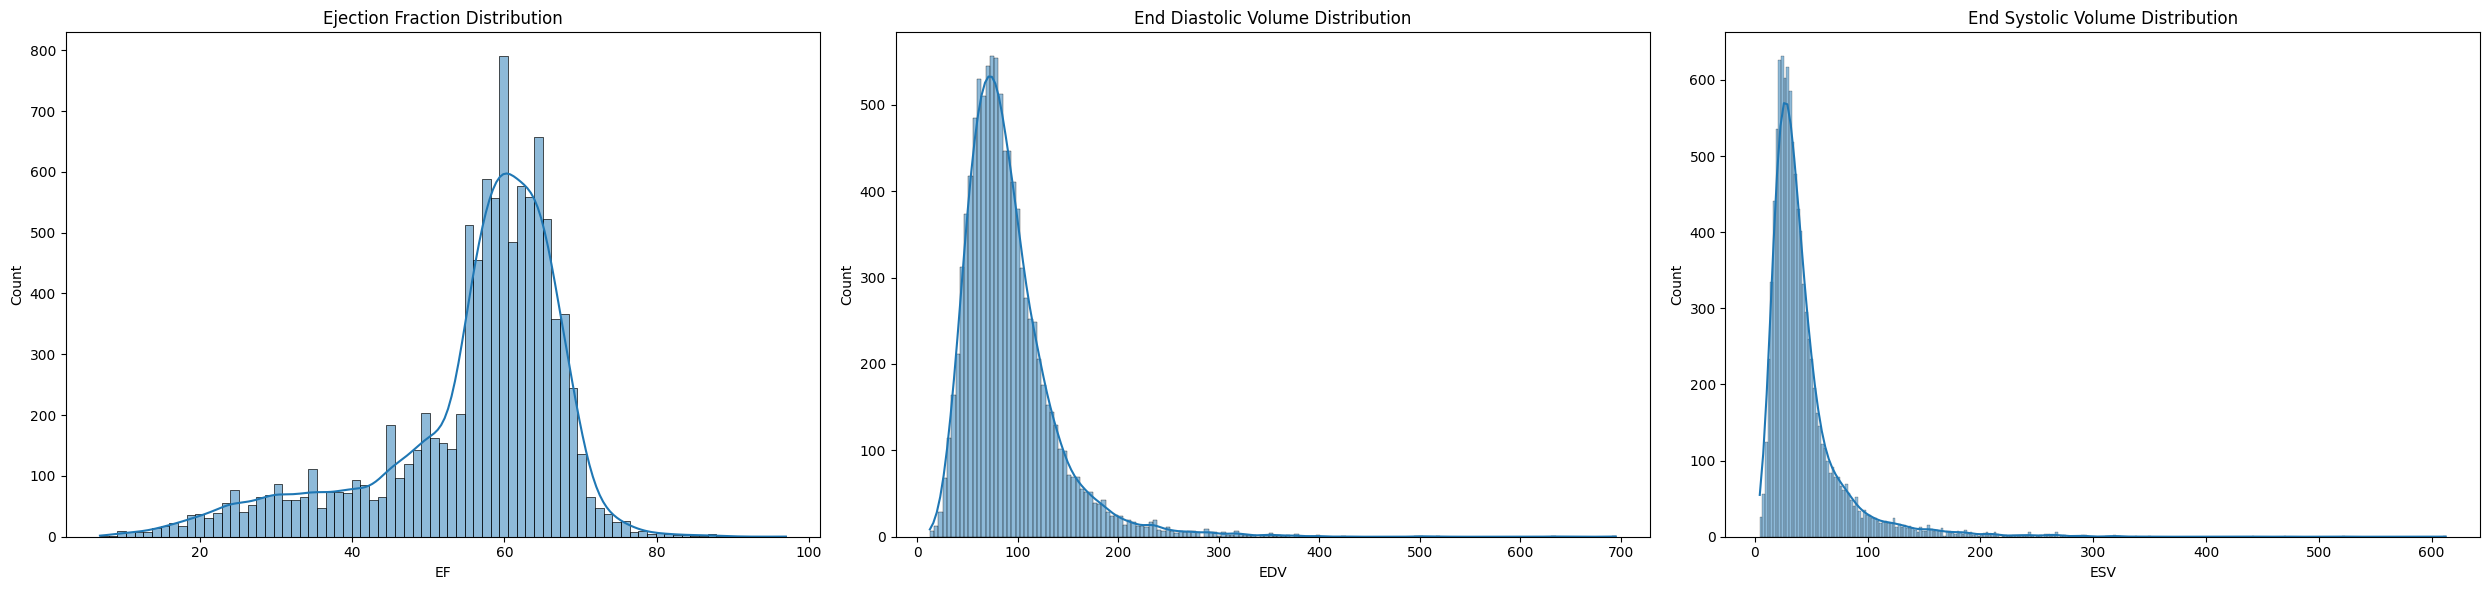

In [ ]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 3, 1)
sns.histplot(df['EF'], kde=True)
plt.title('Ejection Fraction Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['EDV'], kde=True)
plt.title('End Diastolic Volume Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['ESV'], kde=True)
plt.title('End Systolic Volume Distribution')

plt.tight_layout()
plt.show()

<ipython-input-318-1c9ab57d4197>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


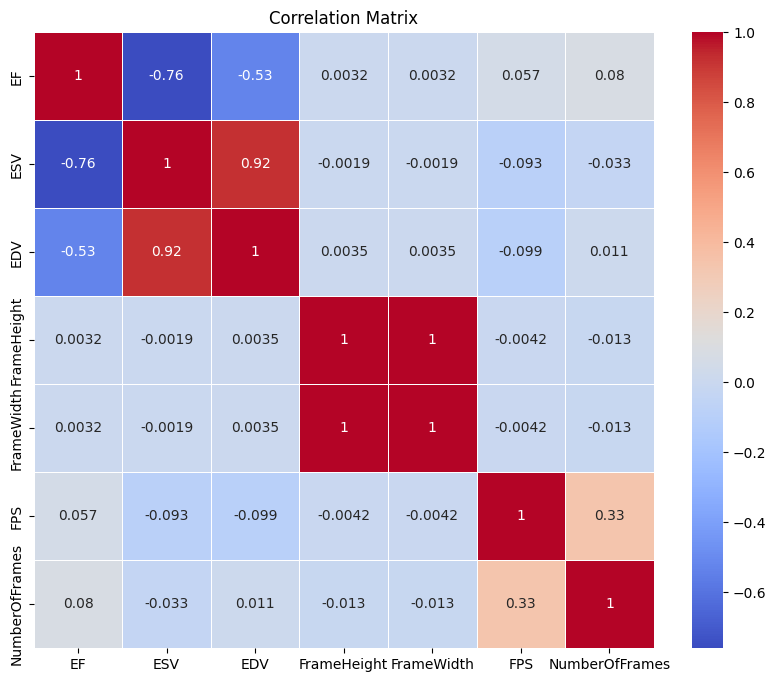

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
volume_df=pd.read_csv("/content/EchoVision Data/VolumeTracings.csv")
volume_df.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


In [ ]:
volume_df.shape

(425010, 6)

In [ ]:
volume_df.describe()

,X1,Y1,X2,Y2,Frame
count,425010.000000,425010.000000,425010.000000,425010.000000,425010.000000
mean,50.450428,49.543699,69.736557,47.717532,74.380577
std,7.012707,18.573019,9.265150,17.865131,41.029798
min,-2.327197,-3.733333,2.046478,-4.106459,0.000000
25%,46.145001,34.712631,63.394252,33.357054,48.000000
50%,50.109005,48.934487,69.783005,46.555860,67.000000
75%,54.177083,63.234491,76.015651,60.636838,99.000000
max,109.276416,116.873407,119.887374,116.083333,686.000000


In [ ]:
volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425010 entries, 0 to 425009
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FileName  425010 non-null  object 
 1   X1        425010 non-null  float64
 2   Y1        425010 non-null  float64
 3   X2        425010 non-null  float64
 4   Y2        425010 non-null  float64
 5   Frame     425010 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 19.5+ MB


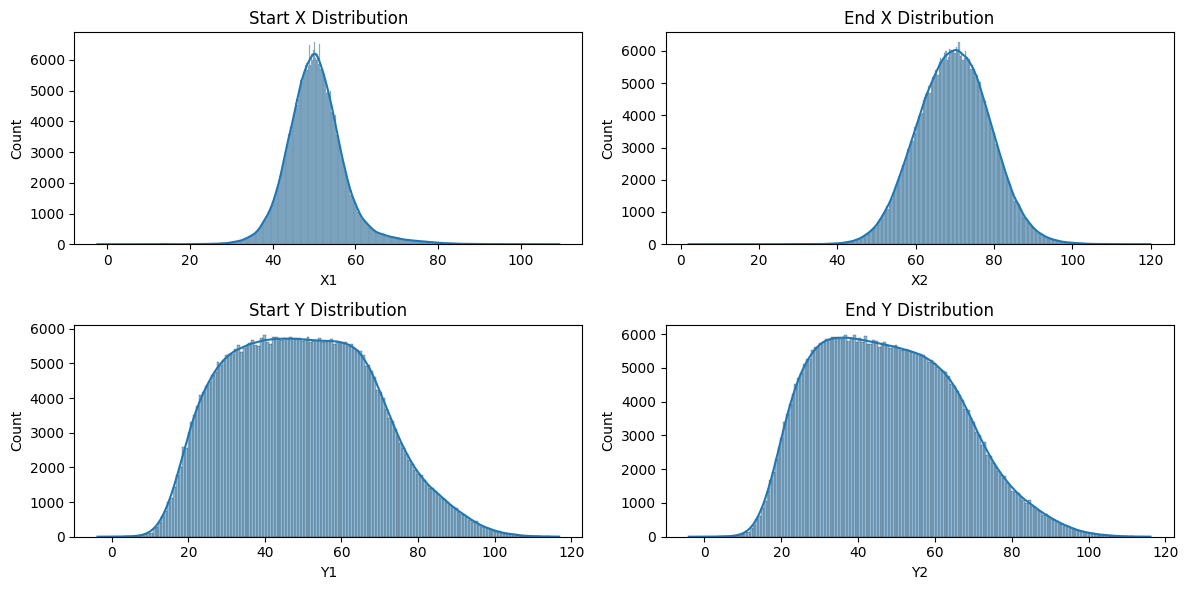

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(volume_df['X1'], kde=True)
plt.title('Start X Distribution')

plt.subplot(2, 2, 2)
sns.histplot(volume_df['X2'], kde=True)
plt.title('End X Distribution')

plt.subplot(2, 2, 3)
sns.histplot(volume_df['Y1'], kde=True)
plt.title('Start Y Distribution')

plt.subplot(2, 2, 4)
sns.histplot(volume_df['Y2'], kde=True)
plt.title('End Y Distribution')

plt.tight_layout()
plt.show()

# **SEGMENTATION**

In [ ]:
data_dir = '/content/EchoVision Data/ESV/ESV_frames'
annotations_dir = '/content/EchoVision Data/ESV/ESV_annotated'

In [ ]:
def load_data(data_dir, annotations_dir):
    data = []
    annotations = []

    for filename in os.listdir(data_dir):
        img = cv2.imread(os.path.join(data_dir, filename))


        data.append(img)




    for filename in os.listdir(annotations_dir):

        mask = cv2.imread(os.path.join(annotations_dir, filename))


        annotations.append(mask)

    return np.array(data,dtype=np.float32), np.array(annotations,dtype=np.float32)


data, annotations = load_data(data_dir, annotations_dir)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data[0:4845], annotations, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_train.dtype

((3846, 112, 112, 3), dtype('float32'))

In [ ]:
y_train.shape, y_train.dtype

((3846, 112, 112, 3), dtype('float32'))

In [ ]:
X_val.shape, X_val.dtype

((962, 112, 112, 3), dtype('float32'))

In [ ]:
y_val.shape, y_val.dtype

((962, 112, 112, 3), dtype('float32'))

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(3, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import SpecificityAtSensitivity, SensitivityAtSpecificity, AUC, Precision, Recall

input_img = Input((112, 112, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.005, batchnorm=True)

model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Cast y_true to float32
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return abs(1 - (numerator + 1) / (denominator + 1))


# Your model compilation
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=dice_loss,
    metrics=[

        SpecificityAtSensitivity(0.2),  # You can adjust the sensitivity value
        SensitivityAtSpecificity(0.2),  # You can adjust the specificity value
        AUC(),
        Precision(),
        Recall(),

    ]
)

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=128, epochs=50,
                    validation_data=(X_val, y_val))


Epoch 1/50
31/31 [==============================] - 8s 120ms/step - loss: 0.0329 - specificity_at_sensitivity_18: 0.8581 - sensitivity_at_specificity_18: 0.7364 - auc_18: 0.5299 - precision_18: 0.6862 - recall_18: 0.2516 - val_loss: 0.0837 - val_specificity_at_sensitivity_18: 0.8722 - val_sensitivity_at_specificity_18: 0.7326 - val_auc_18: 0.5234 - val_precision_18: 0.7107 - val_recall_18: 0.2316
Epoch 2/50
31/31 [==============================] - 3s 103ms/step - loss: 0.0339 - specificity_at_sensitivity_18: 0.8569 - sensitivity_at_specificity_18: 0.7400 - auc_18: 0.5311 - precision_18: 0.6873 - recall_18: 0.2507 - val_loss: 0.0448 - val_specificity_at_sensitivity_18: 0.8545 - val_sensitivity_at_specificity_18: 0.7401 - val_auc_18: 0.5349 - val_precision_18: 0.6900 - val_recall_18: 0.2494
Epoch 3/50
31/31 [==============================] - 3s 103ms/step - loss: 0.0326 - specificity_at_sensitivity_18: 0.8575 - sensitivity_at_specificity_18: 0.7416 - auc_18: 0.5317 - precision_18: 0.6882

In [ ]:

training_loss = results.history['loss'][-1]
training_spec_at_sens_18 = results.history['specificity_at_sensitivity_18'][-1]
training_sens_at_spec_18 = results.history['sensitivity_at_specificity_18'][-1]
training_auc = results.history['auc_18'][-1]
training_precision = results.history['precision_18'][-1]
training_recall = results.history['recall_18'][-1]

val_loss = results.history['val_loss'][-1]
val_spec_at_sens_18 = results.history['val_specificity_at_sensitivity_18'][-1]
val_sens_at_spec_18 = results.history['val_sensitivity_at_specificity_18'][-1]
val_auc = results.history['val_auc_18'][-1]
val_precision = results.history['val_precision_18'][-1]
val_recall = results.history['val_recall_18'][-1]

# Print the values individually
print(f'Training Loss: {training_loss:.2f}')
print(f'Training Specificity at Sensitivity 18: {training_spec_at_sens_18:.2f}')
print(f'Training Sensitivity at Specificity 18: {training_sens_at_spec_18:.2f}')
print(f'Training AUC: {training_auc:.2f}')
print(f'Training Precision: {training_precision:.2f}')
print(f'Training Recall: {training_recall:.2f}')

print('\nValidation Metrics:')
print(f'Validation Loss: {val_loss:.2f}')
print(f'Validation Specificity at Sensitivity 18: {val_spec_at_sens_18:.2f}')
print(f'Validation Sensitivity at Specificity 18: {val_sens_at_spec_18:.2f}')
print(f'Validation AUC: {val_auc:.2f}')
print(f'Validation Precision: {val_precision:.2f}')
print(f'Validation Recall: {val_recall:.2f}')

Training Loss: 0.03
Training Specificity at Sensitivity 18: 0.91
Training Sensitivity at Specificity 18: 0.72
Training AUC: 0.51
Training Precision: 0.72
Training Recall: 0.26

Validation Metrics:
Validation Loss: 0.04
Validation Specificity at Sensitivity 18: 0.91
Validation Sensitivity at Specificity 18: 0.71
Validation AUC: 0.51
Validation Precision: 0.72
Validation Recall: 0.27


In [ ]:
model.save('segmentation_model_edv.h5', save_format='h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model_path = "segmentation_model_edv.h5"
loaded_model = load_model(model_path)


In [ ]:
def prediction(input_image):
  input_image=cv2.imread(input_image)
  input_image1 = input_image.reshape(1, 112, 112, 3)
  predict=loaded_model.predict(input_image1)

  threshold = 0.5
  binary_mask = (predict > threshold).astype(np.uint8)
  segmented_image = (predict * 255).astype(np.uint8)
  cv2.imwrite("segment.jpg",segmented_image[0])


In [ ]:
def extract_green(image_path, output_path):

    original_image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    green_part = cv2.bitwise_and(original_image, original_image, mask=green_mask)
    cv2.imwrite(output_path, green_part)




In [ ]:
def overlay_green_mask(background_image_path, mask_image_path, output_path):

    background_image = cv2.imread(background_image_path)
    mask_image = cv2.imread(mask_image_path, cv2.IMREAD_UNCHANGED)
    mask_image = cv2.resize(mask_image, (background_image.shape[1], background_image.shape[0]))
    inverted_mask = cv2.bitwise_not(mask_image[:, :, 1])
    background_without_green = cv2.bitwise_and(background_image, background_image, mask=inverted_mask)
    result = cv2.add(background_without_green, mask_image)
    cv2.imwrite(output_path, result)




In [ ]:
def plot(input_image):
  img1=cv2.imread("annotated.jpg")
  img=cv2.imread("mask.jpg")
  input_image=cv2.imread(input_image)
  plt.figure(figsize=(25, 10))
  plt.subplot(1, 4, 1)
  plt.imshow(input_image)
  plt.title('Test Image')
  plt.subplot(1, 4, 2)
  plt.imshow(img)
  plt.title('Mask')
  plt.subplot(1, 4, 3)
  plt.imshow(img1)
  plt.title('Annotated Image')
  plt.show()


1/1 [==============================] - 0s 245ms/step


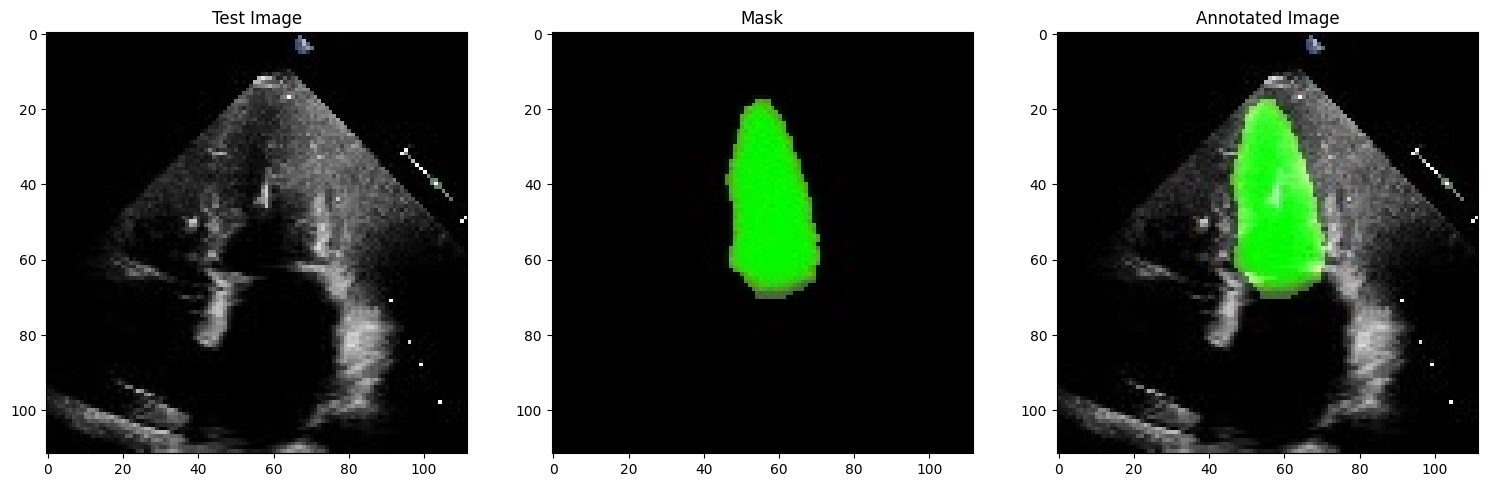

In [ ]:
input_image="/content/EchoVision Data/EDV/EDV_frames/0X102AE9C68B2C46DA.jpg"
prediction(input_image)
extract_green("segment.jpg","mask.jpg")
overlay_green_mask(input_image,"mask.jpg", "annotated.jpg")
plot(input_image)

1/1 [==============================] - 0s 18ms/step


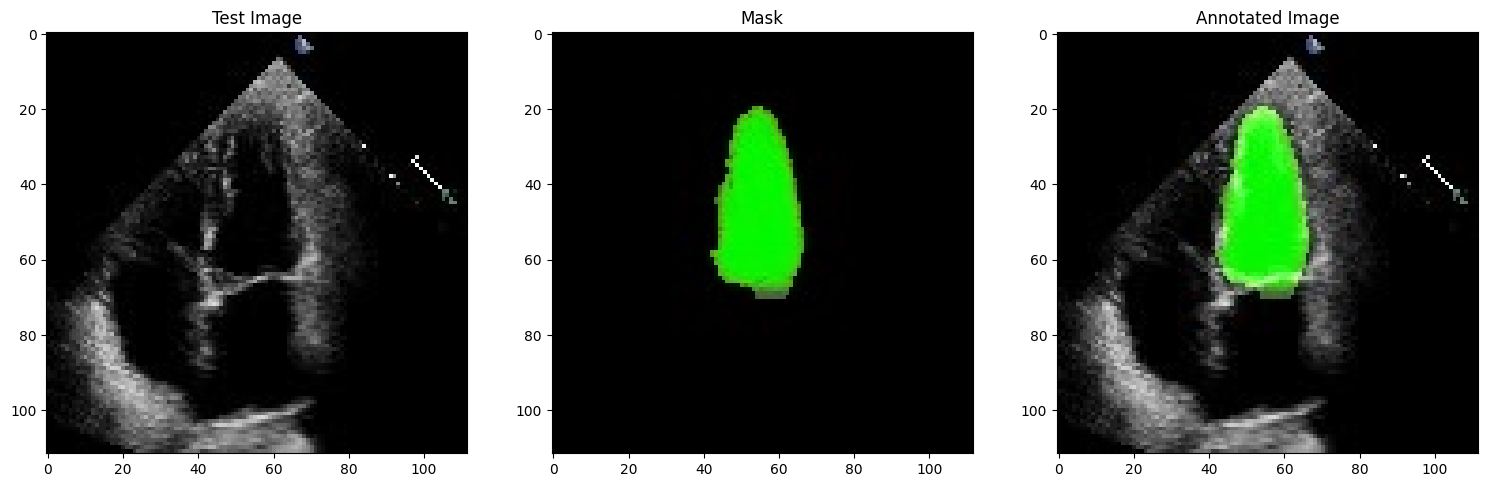

In [ ]:
input_image="/content/EchoVision Data/EDV/EDV_frames/0X1055D6B76E5D7556.jpg"
prediction(input_image)
extract_green("segment.jpg","mask.jpg")
overlay_green_mask(input_image,"mask.jpg", "annotated.jpg")
plot(input_image)

1/1 [==============================] - 0s 18ms/step


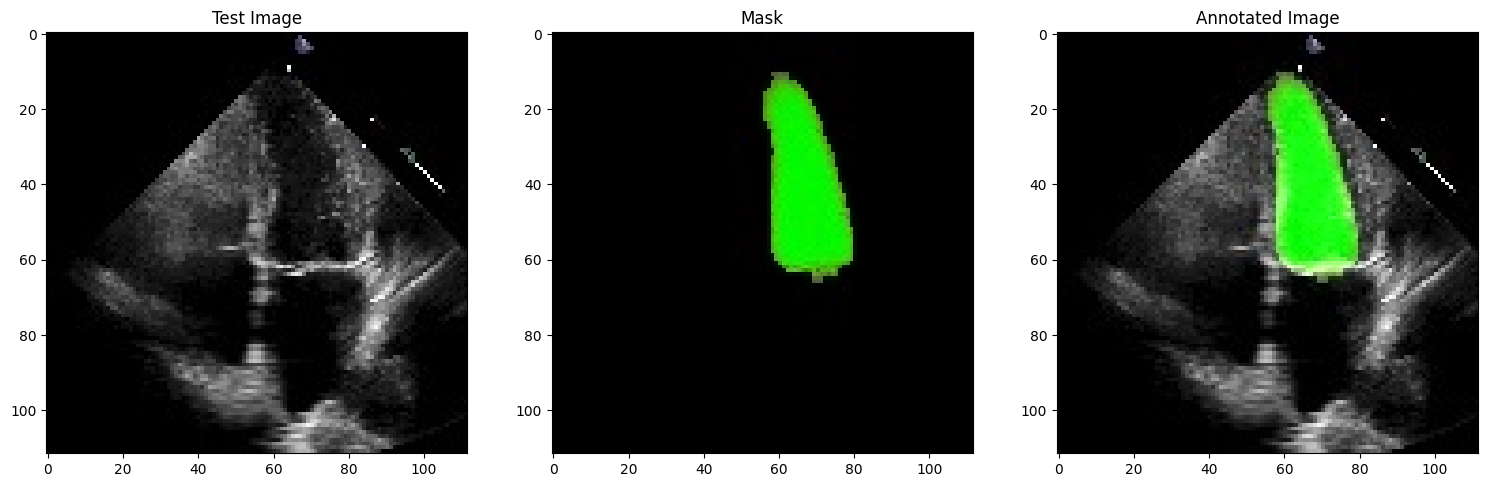

In [ ]:
input_image="/content/EchoVision Data/EDV/EDV_frames/0X10E197789006C3D5.jpg"
prediction(input_image)
extract_green("segment.jpg","mask.jpg")
overlay_green_mask(input_image,"mask.jpg", "annotated.jpg")
plot(input_image)

# **ESV**

In [ ]:
df=pd.read_csv("/content/EchoVision Data/CSVtrain.csv")
df.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
1,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
2,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
3,0X100E3B8D3280BEC5,36.573739,81.747281,128.885543,112,112,38,101,TRAIN
4,0X100E491B3CD58DE2,33.991745,76.865569,116.448419,112,112,50,226,TRAIN


In [ ]:
df_val=pd.read_csv("/content/EchoVision Data/CSVval.csv")

In [ ]:
df.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
1,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
2,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
3,0X100E3B8D3280BEC5,36.573739,81.747281,128.885543,112,112,38,101,TRAIN
4,0X100E491B3CD58DE2,33.991745,76.865569,116.448419,112,112,50,226,TRAIN


In [ ]:
def data(files,df):
  annotated=[]
  esv_values=[]
  for value1, value2 in zip(df['FileName'], df['ESV']):
    f=value1+".jpg"
    if os.path.exists(os.path.join(files,f )):
          img = cv2.imread(os.path.join(files,f ))

          img=np.asarray(img)
          annotated.append(img)

          esv_values.append(value2)
  annotated=np.asarray(annotated)
  esv_values=np.asarray(esv_values)
  return annotated,esv_values


In [ ]:
files="/content/EchoVision Data/ESV/ESV_annotated"

df=pd.read_csv("/content/EchoVision Data/CSVtrain.csv")
annotated_train,esv_values_train=data(files,df)

In [ ]:
annotated_train.shape

(3597, 112, 112, 3)

In [ ]:
esv_values_train.shape

(3597,)

In [ ]:
files="/content/EchoVision Data/ESV/ESV_annotated"
df=pd.read_csv("/content/EchoVision Data/CSVval.csv")
annotated_val,esv_values_val=data(files,df)

In [ ]:
esv_values_val.shape

(633,)

In [ ]:
annotated_val.shape

(633, 112, 112, 3)

In [ ]:
annotated_training = np.concatenate((annotated_train, annotated_val), axis=0)


annotated_training_esv = np.concatenate((esv_values_train, esv_values_val), axis=0)


In [ ]:
annotated_training.shape

(4230, 112, 112, 3)

In [ ]:
import tensorflow as tf
from tensorflow import keras

def build_densenet(input_shape):
    model = keras.applications.DenseNet121(
        include_top=False,
        weights=None,
        input_tensor=keras.layers.Input(shape=input_shape),
        pooling='avg',
    )

    for layer in model.layers:
        layer.trainable = True

    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(model.layers[-1].output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = keras.layers.BatchNormalization()(x)

    output = keras.layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=model.input, outputs=output)

    # Implement early stopping
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    return model, early_stopping



In [ ]:
input_shape = annotated_train[0].shape
from tensorflow.keras.metrics import RootMeanSquaredError

model, early_stopping = build_densenet(input_shape)

model.compile(
    optimizer='adam',
    loss= 'mae',
    metrics=[RootMeanSquaredError()]
)


batch_size = 42
epochs = 100
history = model.fit(
    annotated_training, annotated_training_esv,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(annotated_val, esv_values_val),

)


model.save('densenet_esv_prediction_model.h5')

Epoch 1/100
101/101 [==============================] - 61s 116ms/step - loss: 43.6251 - root_mean_squared_error: 56.3696 - val_loss: 248.5997 - val_root_mean_squared_error: 253.6427
Epoch 2/100
101/101 [==============================] - 8s 80ms/step - loss: 39.2361 - root_mean_squared_error: 53.9752 - val_loss: 173.8003 - val_root_mean_squared_error: 188.9473
Epoch 3/100
101/101 [==============================] - 8s 81ms/step - loss: 32.5423 - root_mean_squared_error: 48.5557 - val_loss: 32896.3398 - val_root_mean_squared_error: 34896.2773
Epoch 4/100
101/101 [==============================] - 8s 80ms/step - loss: 24.3840 - root_mean_squared_error: 41.7299 - val_loss: 93731.4844 - val_root_mean_squared_error: 96969.6094
Epoch 5/100
101/101 [==============================] - 8s 80ms/step - loss: 19.1726 - root_mean_squared_error: 36.2056 - val_loss: 747.7093 - val_root_mean_squared_error: 783.3352
Epoch 6/100
101/101 [==============================] - 8s 79ms/step - loss: 17.6849 - root

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
img=cv2.imread("/content/EchoVision Data/ESV/ESV_annotated/0X1002E8FBACD08477.jpg")
new_data = img.reshape(1, 112, 112, 3)

predictions = model.predict(new_data)

1/1 [==============================] - 0s 32ms/step


In [ ]:
predictions

array([[30.795023]], dtype=float32)

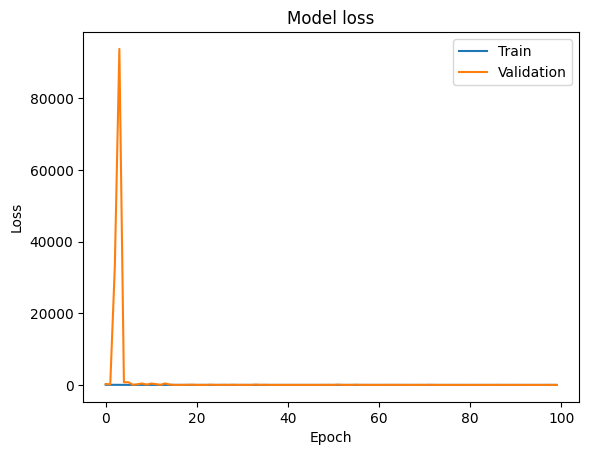

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# **EDV**

In [ ]:
df=pd.read_csv("/content/EchoVision Data/FileList.csv")
df.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [ ]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

files="/content/EchoVision Data/EDV/EDV_annotated"

annotated=[]
edv_values=[]

for value1, value2 in zip(df['FileName'], df['EDV']):

          f=value1+".jpg"
          if os.path.exists(os.path.join(files,f )):
            img = cv2.imread(os.path.join(files,f ))

            img=np.asarray(img)
            annotated.append(img)

            edv_values.append(value2)
annotated=np.asarray(annotated)
edv_values=np.asarray(edv_values)

X_train, X_val, y_train, y_val = train_test_split(annotated, edv_values, test_size=0.2, random_state=42)

def build_densenet(input_shape):
    model = keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=keras.layers.Input(shape=input_shape),
        pooling='avg',
    )
    x = keras.layers.Dense(128, activation='relu')(model.layers[-1].output)
    output = keras.layers.Dense(1, activation='linear')(x)
    return keras.Model(inputs=model.input, outputs=output)

In [ ]:
X_train.shape

(3876, 112, 112, 3)

In [ ]:
input_shape = X_train[0].shape
model = build_densenet(input_shape)

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)


batch_size = 25
epochs = 100

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

model.save('densenet_edv_prediction_model.h5')

Epoch 1/100
156/156 [==============================] - 59s 84ms/step - loss: 1588.2617 - mae: 27.0806 - val_loss: 159745.5469 - val_mae: 384.7708
Epoch 2/100
156/156 [==============================] - 11s 73ms/step - loss: 902.6874 - mae: 20.4911 - val_loss: 9923.7764 - val_mae: 83.6452
Epoch 3/100
156/156 [==============================] - 11s 74ms/step - loss: 804.5488 - mae: 19.2586 - val_loss: 13160.7021 - val_mae: 99.6662
Epoch 4/100
156/156 [==============================] - 12s 76ms/step - loss: 689.2256 - mae: 18.2043 - val_loss: 572.9266 - val_mae: 17.5634
Epoch 5/100
156/156 [==============================] - 12s 74ms/step - loss: 593.9108 - mae: 17.1593 - val_loss: 900.8259 - val_mae: 22.6831
Epoch 6/100
156/156 [==============================] - 12s 75ms/step - loss: 582.2162 - mae: 17.1283 - val_loss: 2717.4495 - val_mae: 42.2654
Epoch 7/100
156/156 [==============================] - 11s 72ms/step - loss: 519.4670 - mae: 16.2910 - val_loss: 1196.4299 - val_mae: 27.8858
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
img=cv2.imread("/content/EchoVision Data/EDV/EDV_annotated/0X13A3E602CCA508D6.jpg")
new_data = img.reshape(1, 112, 112, 3)

predictions = model.predict(new_data)


1/1 [==============================] - 0s 29ms/step


In [ ]:
predictions

array([[69.41886]], dtype=float32)

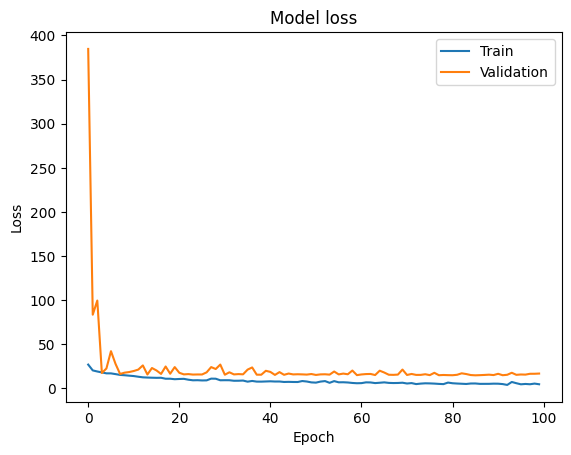

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# **Effusion Fraction Calculation**

In [ ]:
def ef_calculation(edv,esv):
  ef=((esv-edv)/edv)*100
  print(ef)
  if(ef>=52 and ef<=72):
    print("Normal")
  elif ef>=41 and ef<=53:
    print("Mildly Abnormal")
  elif ef>=30 and ef<=40:
    print("Moderately Abnoraml")
  else:
      print("Severely Abnormal")
  return None

In [ ]:
from google.colab.patches import cv2_imshow

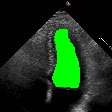

In [ ]:
edv_img="/content/EchoVision Data/EDV/EDV_annotated/0X101C388397F66EDB.jpg"
edv_img=cv2.imread(edv_img)
cv2_imshow(edv_img)

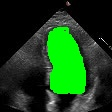

In [ ]:
esv_img="/content/EchoVision Data/ESV/ESV_annotated/0X101C388397F66EDB.jpg"
esv_img=cv2.imread(esv_img)
cv2_imshow(esv_img)

In [ ]:
model_esv = tf.keras.models.load_model('/content/densenet_edv_prediction_model.h5')
model_edv = tf.keras.models.load_model('/content/densenet_edv_prediction_model.h5')


In [ ]:
esv_img=esv_img.reshape(1, 112, 112, 3)
edv_img=edv_img.reshape(1, 112, 112, 3)

In [ ]:
edv_prediction=model_edv.predict(edv_img)
esv_prediction=model_esv.predict(esv_img)

1/1 [==============================] - 0s 32ms/step


In [ ]:
edv_prediction

array([[101.55975]], dtype=float32)

In [ ]:
esv_prediction

array([[201.28409]], dtype=float32)

In [ ]:
ef_calculation(edv_prediction,esv_prediction)

[[98.19277]]
Severely Abnormal


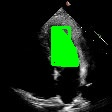

In [ ]:
edv_img="/content/EchoVision Data/EDV/EDV_annotated/0X1002E8FBACD08477.jpg"
edv_img=cv2.imread(edv_img)
cv2_imshow(edv_img)

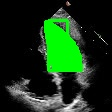

In [ ]:
esv_img="/content/EchoVision Data/ESV/ESV_annotated/0X1002E8FBACD08477.jpg"
esv_img=cv2.imread(esv_img)
cv2_imshow(esv_img)

In [ ]:
esv_img=esv_img.reshape(1, 112, 112, 3)
edv_img=edv_img.reshape(1, 112, 112, 3)

In [ ]:
edv_prediction=model_edv.predict(edv_img)
esv_prediction=model_esv.predict(esv_img)

1/1 [==============================] - 0s 32ms/step


In [ ]:
print(edv_prediction)
esv_prediction

[[97.03747]]


array([[153.76222]], dtype=float32)

In [ ]:
ef_calculation(edv_prediction,esv_prediction)

[[58.456547]]
Normal
